# Fake Job Listing Detection

In [1]:
import pandas as pd

In [2]:
import re
import string
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix

from wordcloud import WordCloud 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [3]:
df=pd.read_csv("fake_job_postings.csv")

In [4]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [5]:
df.shape

(17880, 18)

In [6]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
columns=['job_id','telecommuting','has_company_logo','has_questions','salary_range','employment_type']
for colu in columns:
    del df[colu]

In [8]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
df.fillna('',inplace=True)

In [10]:
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


In [11]:
df.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

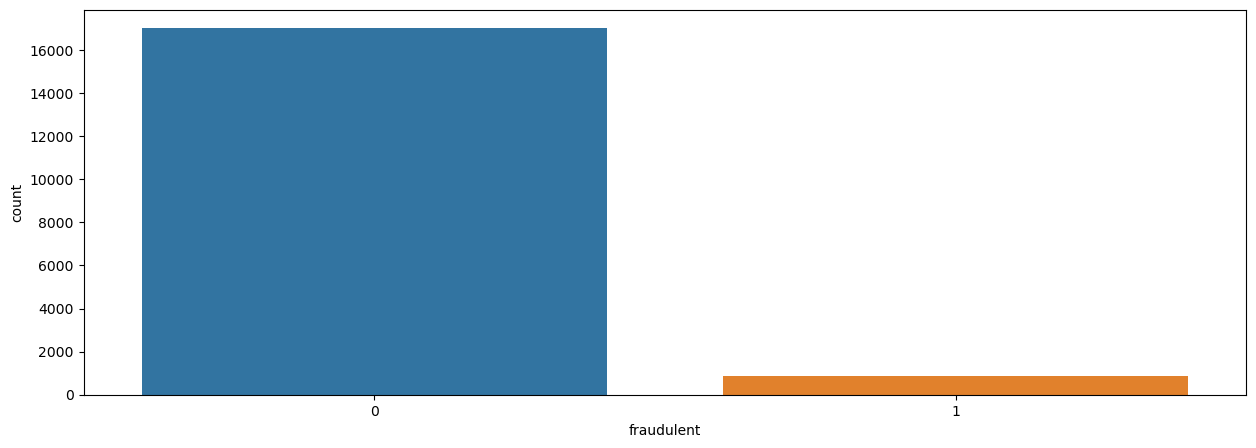

In [12]:
plt.figure(figsize=(15,5))
sns.countplot(x='fraudulent',data=df)
plt.show()

In [13]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [14]:
exp=dict(df.required_experience.value_counts())
del exp['']

In [15]:
exp

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

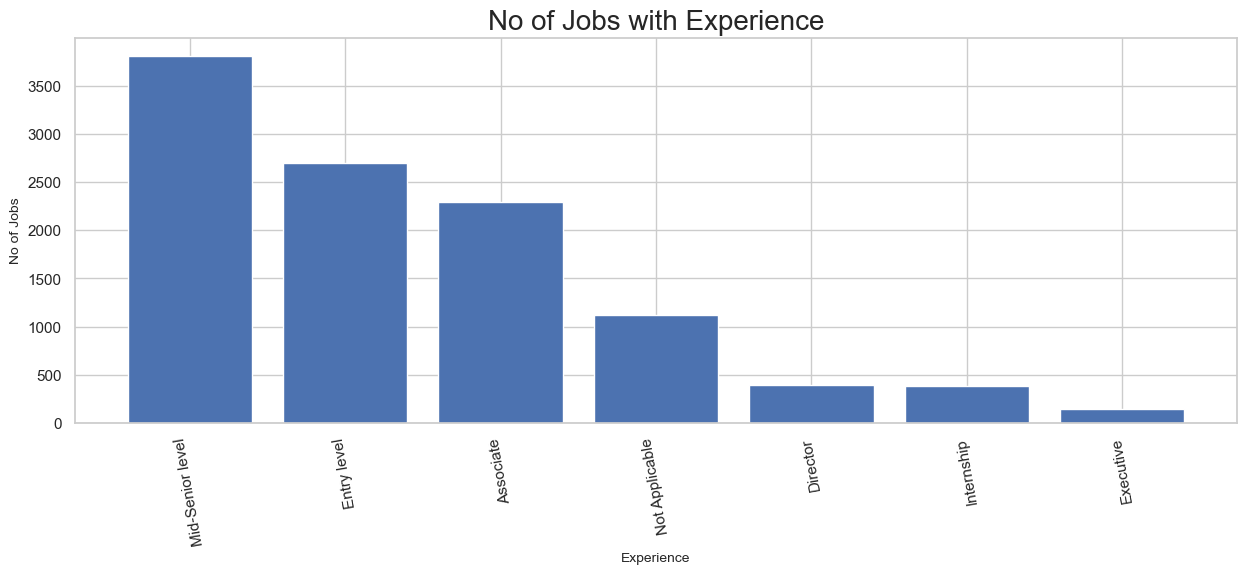

In [16]:
plt.figure(figsize=(15,5))
sns.set_theme(style='whitegrid')
plt.bar(exp.keys(),exp.values())
plt.title("No of Jobs with Experience",size=20)
plt.xlabel("Experience",size=10)
plt.ylabel("No of Jobs",size=10)
plt.xticks(rotation=100)
plt.show()

In [17]:
def split(location):
    i=location.split(",")
    return i[0]
df["country"]=df.location.apply(split)

In [18]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


##### Top 14 country job posting

In [19]:
countr=dict(df.country.value_counts()[:14])
del countr[""]
countr

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80}

Text(0.5, 0, 'countries')

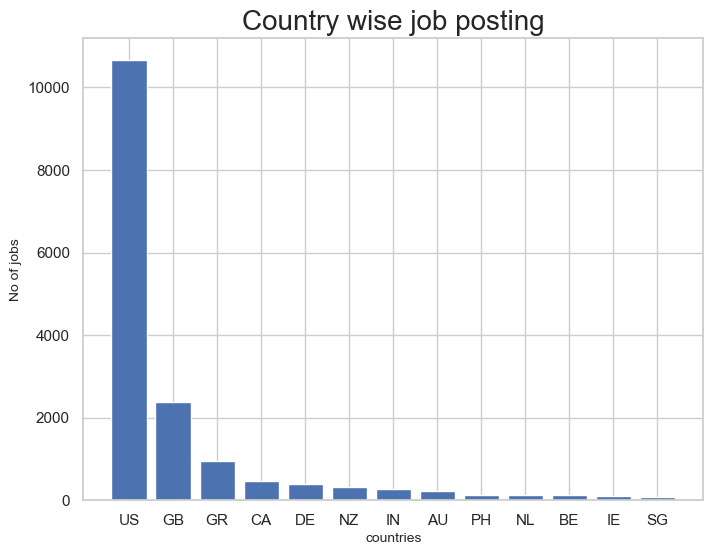

In [20]:
plt.figure(figsize=(8,6))
plt.title("Country wise job posting",size=20)
plt.bar(countr.keys(),countr.values())
plt.ylabel("No of jobs",size=10)
plt.xlabel("countries",size=10)

##### Top 7 Required Education Lavels

In [21]:
edu=dict(df.required_education.value_counts()[:7])
del edu['']
edu

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274,
 'Certification': 170}

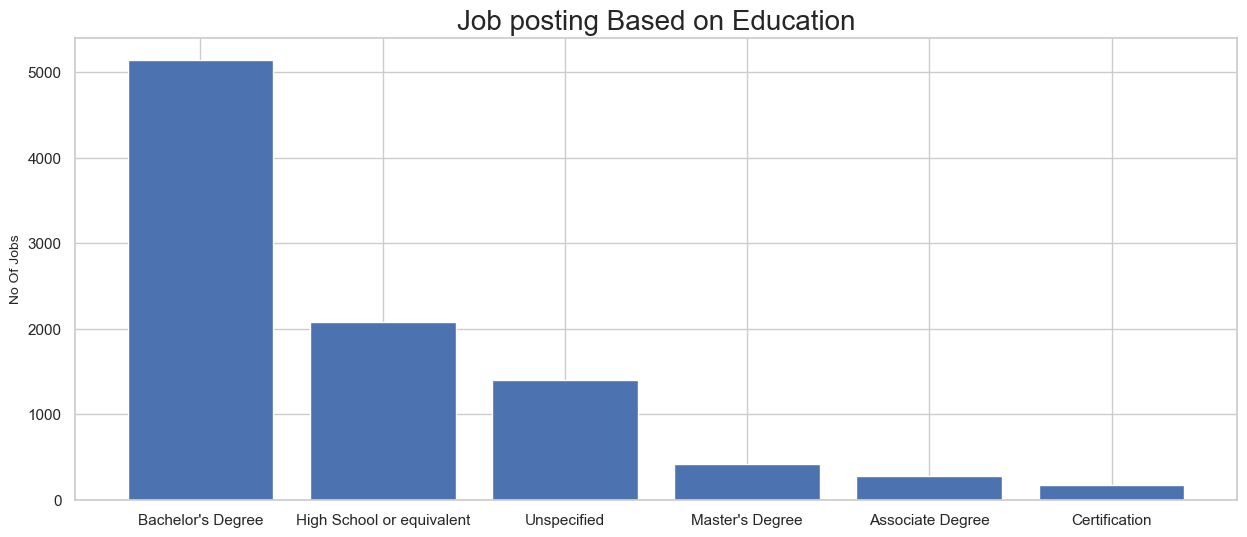

In [22]:
plt.figure(figsize=(15,6))
plt.title("Job posting Based on Education",size=20)
plt.bar(edu.keys(),edu.values())
plt.ylabel("No Of Jobs",size=10)
plt.xlabel=("Education")

##### Job Posted with Not fraudulent

In [23]:
print(df[df.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


#### Job Posted with fraudulent

In [24]:
print(df[df.fraudulent==1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


##### convert the dataset into two columns one is fraudulent and other is text

In [25]:
df['text']=df['title']+df['company_profile']+df['description']+df['requirements']+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [26]:
df.head()

,fraudulent,text
0,0,"Marketing InternWe're Food52, and we've create..."
1,0,Customer Service - Cloud Video Production90 Se...
2,0,Commissioning Machinery Assistant (CMA)Valor S...
3,0,Account Executive - Washington DCOur passion f...
4,0,Bill Review ManagerSpotSource Solutions LLC is...


## create a wordcloud for fraudulent and non fraudulent postings

In [27]:
fraudjobs_text=df[df.fraudulent==1].text
realjobs_text=df[df.fraudulent==0].text

### wordcloud for fraudulent postings

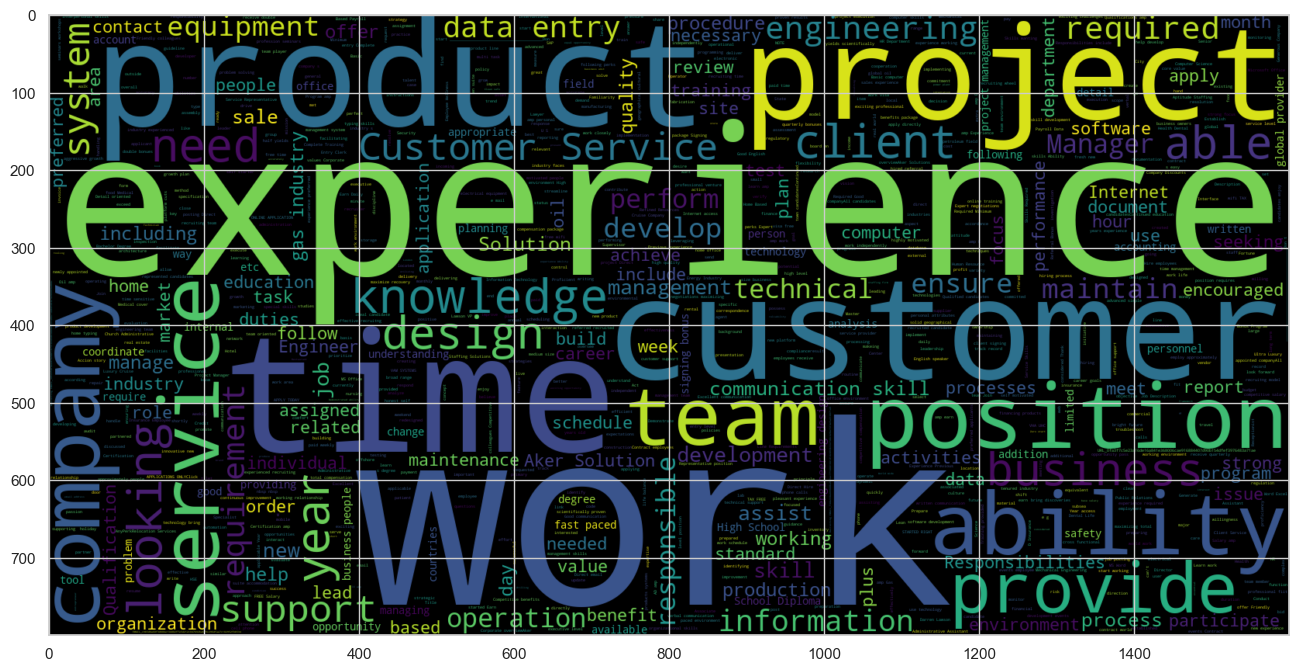

In [28]:
STOPWORDS=spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,24))
wc=WordCloud(min_font_size=3,max_words=3000,width=1600,height=800,stopwords=STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation='bilinear')

### wordcloud for Non-fraudulent postings

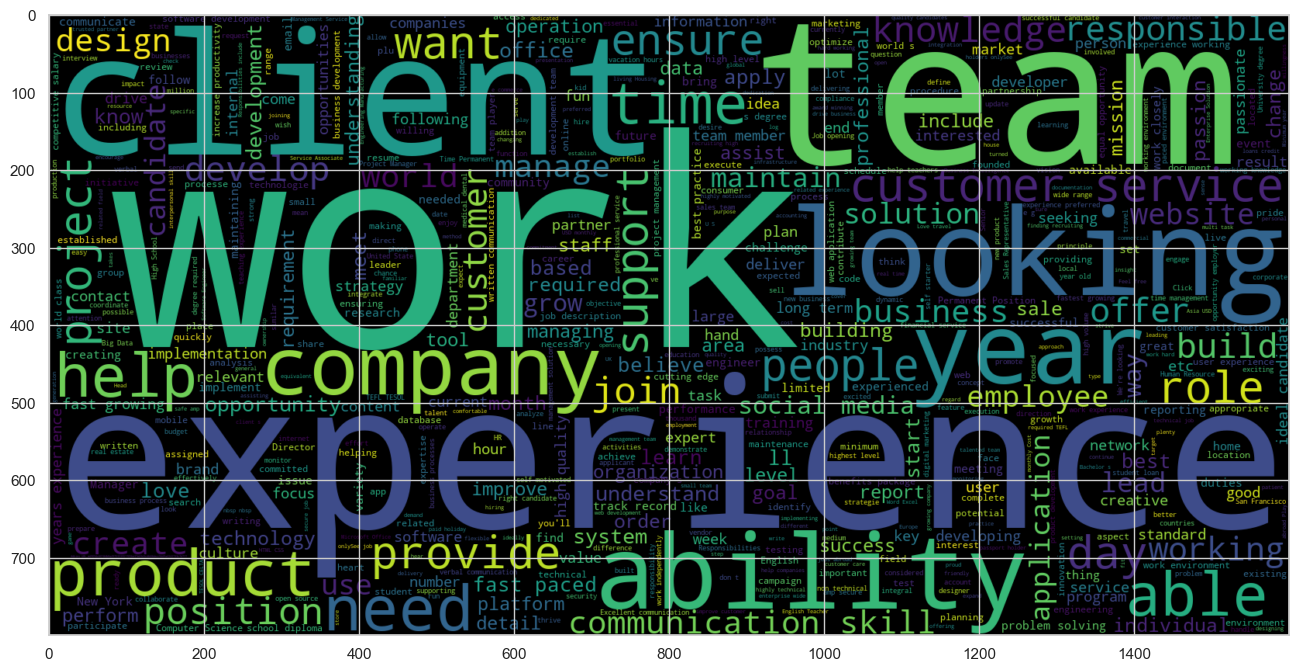

In [29]:
STOPWORDS=spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,24))
wc=WordCloud(min_font_size=3,max_words=3000,width=1600,height=800,stopwords=STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc,interpolation='bilinear')

In [30]:
punctuation=string.punctuation
nlp=spacy.load("en_core_web_sm")
stop_words=spacy.lang.en.stop_words.STOP_WORDS
parser=English()
def spacy_tokenizer(sentence):
    mytokens=parser(sentence)
    mytokens=[word.lenna_.lower().strip() if word.lenna_ !="-PRON-" else word.lower_ for word in mytokens]
    mytockens=[word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens
class predictors(TransformerMixin):
    def transform(self,x,**transform_params):
        return(clean_text(text) for text in x)
    def fit(self,x,y=None,**fit_params):
        return self
    def get_params(self,deep=True):
        return()
def clean_text(text):
    return text.strip().lower()
    

In [31]:
df['text']=df['text'].apply(clean_text)

In [32]:
cv=TfidfVectorizer(max_features=100)
x=cv.fit_transform(df['text'])
df1=pd.DataFrame(x.toarray(),columns=cv.get_feature_names())
df.drop(["text"],axis=1,inplace=True)
main_df=pd.concat([df1,df],axis=1)

C:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
main_df.head()

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041625,0.000000,0.042595,0.036633,0.000000,0.758231,0.000000,0.079104,0.000000,...,0.000000,0.000000,0.186826,0.051273,0.068373,0.000000,0.000000,0.000000,0.000000,0
1,0.021854,0.094723,0.035322,0.024233,0.041682,0.029729,0.489657,0.056506,0.060004,0.052543,...,0.000000,0.077849,0.165335,0.043755,0.116693,0.099110,0.000000,0.204484,0.130182,0
2,0.000000,0.000000,0.176827,0.000000,0.041732,0.089294,0.396872,0.113150,0.000000,0.000000,...,0.000000,0.062355,0.307425,0.058410,0.000000,0.000000,0.000000,0.094492,0.074480,0
3,0.023340,0.000000,0.018862,0.000000,0.000000,0.095250,0.697269,0.000000,0.032042,0.037410,...,0.023224,0.049885,0.075676,0.046730,0.000000,0.105849,0.019858,0.050397,0.059586,0
4,0.000000,0.000000,0.068085,0.000000,0.040171,0.028652,0.606750,0.081688,0.115660,0.000000,...,0.000000,0.000000,0.159345,0.028113,0.037489,0.000000,0.035840,0.030319,0.107542,0


(array([1.4928e+04, 2.1570e+03, 5.5300e+02, 1.5000e+02, 5.7000e+01,
        2.1000e+01, 1.0000e+01, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.06365955, 0.1273191 , 0.19097865, 0.2546382 ,
        0.31829775, 0.3819573 , 0.44561685, 0.5092764 , 0.57293595,
        0.6365955 ]),
 <BarContainer object of 10 artists>)

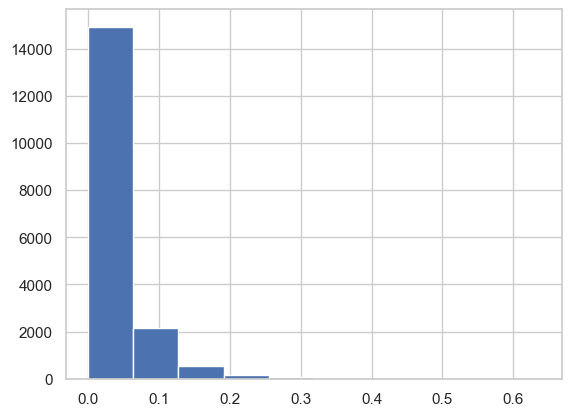

In [34]:
m=main_df['ability']
plt.hist(m)

C:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fraudulent', ylabel='Density'>

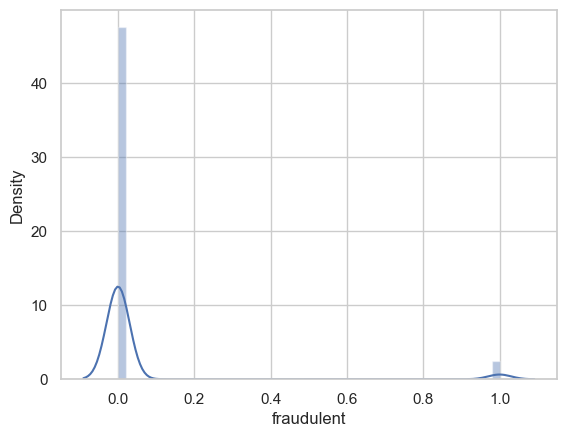

In [35]:
sns.distplot(main_df['fraudulent'])

In [36]:
y=main_df['fraudulent']
x=main_df[['ability','about','all','also','amp','an','and','are','as','at','who','will','with','work','working','world','years','you','your']]
#y=main_df.iloc[:,-1]
#x=main_df.iloc[:,:-1]

x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(12516, 19)
(5364, 19)
(12516,)
(5364,)


# Random Forest Algorithm

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(x_train,y_train)


In [39]:
pred=rfc.predict(x_test)
accuracy=accuracy_score(y_test,pred)
print(accuracy*100)

97.0171513795675


In [40]:
print("Classification Report\n")
print(classification_report(y_test,pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test,pred))

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5111
           1       0.99      0.37      0.54       253

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.76      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5110    1]
 [ 159   94]]


# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression 
lr=LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression()

In [42]:
lr.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
score=lr.score(x_test,y_test)

In [44]:
score=score*100

In [45]:
score

95.28337061894109

### Gaussian Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

In [47]:
gnb = GaussianNB()

In [48]:
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}")


Accuracy: 91.83


In [49]:
print("Classification Report\n")
print(classification_report(y_test,pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test,pred))

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5111
           1       0.99      0.37      0.54       253

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.76      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5110    1]
 [ 159   94]]
